# DL TRAINING NOTEBOOK

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from src import (config, describe_data, features,
                 preprocess, training, utils)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# DATA LOAD

In [4]:
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [5]:
# ===== MODEL SAMPLES ======
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')

valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')

test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


In [7]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Ion type list
ion_list = list(np.arange(0,100,1.0))

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


# DEEP LEARNING PREPPROCESSING

We need to create a 3D array, where the 1st dimension are samples, 2nd dimension are features and the 3rd dimension are the time steps. Since the raw time steps repeat given a different ion type, i.e. `m/z` we need to construct features with respect to the ion type. So we will have `1.0_temp`, `1.0_abundance`, `2.0_temp`, `2.0_abundance`, etc. Furthermore, the time is measured in seconds and time steps are not uniform and even across samples. Different time measurements are across samples. Hence, we will first compute the maximum time present in the training, validation and test samples and then aggregate all the data in 10 second time intervals. This will provide a full data array instead of a sparse one. Also it will significantly reduce the training size.

In [8]:
# COMPUTE MAXIMUM TIME ACROSS ALL SAMPLES
max_time = preprocess.compute_max_time_samples(metadata)
max_time

100%|██████████| 1570/1570 [01:53<00:00, 13.84it/s]


5248.14

**Are the time steps and `m/z` values unique?** We need only one row per sample given one time step. Hence, we need to ensure that the time steps and the ion types are unique. We should add this check (that one row is being created for one sample and one time period) when we construct the final array.

In the `sam_testbed` samples, there are differences in temperature per `time_bin` and the ion type, where per one `temp_bin`we get different temperature values per diferent ion type. This leads to duplicates in the rows per time step. See sample 765 for example.

```python
ht['check'] = ht.groupby(['time', 'm/z'])['time'].transform('count')
ht[ht['check'] > 1]
```

In [9]:
# ===== CREATE TS DF - TRAIN =====
df_meta = metadata[metadata.split == 'train']
fts_dl_ts = features.dl_ts(df_meta, max_time)
print(fts_dl_ts.shape)
fts_dl_ts.head()

100%|██████████| 766/766 [05:48<00:00,  2.20it/s]

(402150, 104)


,time_bin,temp,temp_osc_time,mz_0_abund,mz_1_abund,mz_2_abund,mz_3_abund,mz_5_abund,mz_6_abund,mz_7_abund,...,mz_92_abund,mz_93_abund,mz_94_abund,mz_95_abund,mz_96_abund,mz_97_abund,mz_98_abund,mz_99_abund,sample_id,instrument_type
0,"[0.0, 10.0)",35.289,0.0,0.000172,0.000151,0.000045,0.000126,0.000011,1.914604e-06,1.719285e-06,...,0.000002,1.339071e-06,9.866536e-07,1.572230e-06,0.000002,0.000003,5.738569e-07,2.132724e-06,S0000,commercial
1,"[10.0, 20.0)",35.420,0.0,0.000182,0.000163,0.000042,0.000125,0.000007,3.390866e-06,1.932152e-06,...,0.000001,2.459132e-06,2.169595e-06,2.155304e-06,0.000002,0.000002,1.218669e-06,2.416544e-06,S0000,commercial
2,"[20.0, 30.0)",35.680,0.0,0.000158,0.000112,0.000038,0.000186,0.000007,8.339909e-07,1.657618e-06,...,0.000002,2.039618e-06,1.211452e-06,5.682833e-07,0.000002,0.000002,1.589236e-06,9.542845e-07,S0000,commercial
3,"[30.0, 40.0)",36.329,0.0,0.000184,0.000113,0.000031,0.000170,0.000004,1.631496e-06,5.990105e-07,...,0.000000,7.548532e-07,3.817495e-06,1.514565e-06,0.000002,0.000002,1.403524e-06,9.485680e-07,S0000,commercial
4,"[40.0, 50.0)",37.293,0.0,0.000170,0.000136,0.000062,0.000192,0.000005,2.161267e-06,1.754442e-06,...,0.000002,8.333112e-07,2.654991e-06,2.064771e-06,0.000002,0.000002,1.821823e-06,1.904639e-06,S0000,commercial


We need to label encode all the non numeric features since the neural network handles only numeric values. In the code below we check which features are not numeric and encode them. Note that the `time_bin` and `sample_id` are not features so no need to encode them.

In [10]:
# ===== ENCODE NON NUMERIC FEATURES =====
print(f'Non numeric features: {[i for i in fts_dl_ts if fts_dl_ts[i].dtype not in ["int", "float"]]}')
#print(fts_dl_ts['instrument_type'].value_counts())
fts_dl_ts['instrument'] = np.where(fts_dl_ts['instrument_type'] == 'commercial', 1, 0)
#print(fts_dl_ts['instrument'].value_counts())
del fts_dl_ts['instrument_type']

Non numeric features: ['time_bin', 'sample_id', 'instrument_type']


In [11]:
# ===== NORMALIZE TEMPERATURE =====
sc = MinMaxScaler(feature_range=(0,1))
fts_dl_ts['temp_sc'] = sc.fit_transform(fts_dl_ts['temp'].values.reshape((fts_dl_ts.shape[0], 1)))
del fts_dl_ts['temp']

In [12]:
fts_dl_ts

,time_bin,temp_osc_time,mz_0_abund,mz_1_abund,mz_2_abund,mz_3_abund,mz_5_abund,mz_6_abund,mz_7_abund,mz_8_abund,...,mz_93_abund,mz_94_abund,mz_95_abund,mz_96_abund,mz_97_abund,mz_98_abund,mz_99_abund,sample_id,instrument,temp_sc
0,"[0.0, 10.0)",0.0,0.000172,0.000151,0.000045,0.000126,0.000011,1.914604e-06,1.719285e-06,0.000003,...,1.339071e-06,9.866536e-07,1.572230e-06,0.000002,0.000003,5.738569e-07,2.132724e-06,S0000,1,0.063589
1,"[10.0, 20.0)",0.0,0.000182,0.000163,0.000042,0.000125,0.000007,3.390866e-06,1.932152e-06,0.000004,...,2.459132e-06,2.169595e-06,2.155304e-06,0.000002,0.000002,1.218669e-06,2.416544e-06,S0000,1,0.063673
2,"[20.0, 30.0)",0.0,0.000158,0.000112,0.000038,0.000186,0.000007,8.339909e-07,1.657618e-06,0.000004,...,2.039618e-06,1.211452e-06,5.682833e-07,0.000002,0.000002,1.589236e-06,9.542845e-07,S0000,1,0.063841
3,"[30.0, 40.0)",0.0,0.000184,0.000113,0.000031,0.000170,0.000004,1.631496e-06,5.990105e-07,0.000004,...,7.548532e-07,3.817495e-06,1.514565e-06,0.000002,0.000002,1.403524e-06,9.485680e-07,S0000,1,0.064261
4,"[40.0, 50.0)",0.0,0.000170,0.000136,0.000062,0.000192,0.000005,2.161267e-06,1.754442e-06,0.000002,...,8.333112e-07,2.654991e-06,2.064771e-06,0.000002,0.000002,1.821823e-06,1.904639e-06,S0000,1,0.064884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,"[5200.0, 5210.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,0,NaN
521,"[5210.0, 5220.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,0,NaN
522,"[5220.0, 5230.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,0,NaN
523,"[5230.0, 5240.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,0,NaN


In [13]:
# ===== FEATURES LIST =====
features_dl = [i for i in fts_dl_ts if i not in ['sample_id', 'time_bin']]
print(f'Number of features: {len(features_dl)}')
#print(features_dl)

Number of features: 102


Also, we need to replace the NaN values. Since zero is a meaningful value in the sample we will assign a value of -1 to all NaN values.

In [14]:
# ===== FIX NaN VALUES =====
print(fts_dl_ts.isnull().sum())
fts_dl_ts[features_dl] = fts_dl_ts[features_dl].fillna(-1)

time_bin              0
temp_osc_time    270491
mz_0_abund       283447
mz_1_abund       279085
mz_2_abund       271886
                  ...  
mz_98_abund      279730
mz_99_abund      279730
sample_id             0
instrument            0
temp_sc          270490
Length: 104, dtype: int64


In [15]:
fts_dl_ts

,time_bin,temp_osc_time,mz_0_abund,mz_1_abund,mz_2_abund,mz_3_abund,mz_5_abund,mz_6_abund,mz_7_abund,mz_8_abund,...,mz_93_abund,mz_94_abund,mz_95_abund,mz_96_abund,mz_97_abund,mz_98_abund,mz_99_abund,sample_id,instrument,temp_sc
0,"[0.0, 10.0)",0.0,0.000172,0.000151,0.000045,0.000126,0.000011,1.914604e-06,1.719285e-06,0.000003,...,1.339071e-06,9.866536e-07,1.572230e-06,0.000002,0.000003,5.738569e-07,2.132724e-06,S0000,1,0.063589
1,"[10.0, 20.0)",0.0,0.000182,0.000163,0.000042,0.000125,0.000007,3.390866e-06,1.932152e-06,0.000004,...,2.459132e-06,2.169595e-06,2.155304e-06,0.000002,0.000002,1.218669e-06,2.416544e-06,S0000,1,0.063673
2,"[20.0, 30.0)",0.0,0.000158,0.000112,0.000038,0.000186,0.000007,8.339909e-07,1.657618e-06,0.000004,...,2.039618e-06,1.211452e-06,5.682833e-07,0.000002,0.000002,1.589236e-06,9.542845e-07,S0000,1,0.063841
3,"[30.0, 40.0)",0.0,0.000184,0.000113,0.000031,0.000170,0.000004,1.631496e-06,5.990105e-07,0.000004,...,7.548532e-07,3.817495e-06,1.514565e-06,0.000002,0.000002,1.403524e-06,9.485680e-07,S0000,1,0.064261
4,"[40.0, 50.0)",0.0,0.000170,0.000136,0.000062,0.000192,0.000005,2.161267e-06,1.754442e-06,0.000002,...,8.333112e-07,2.654991e-06,2.064771e-06,0.000002,0.000002,1.821823e-06,1.904639e-06,S0000,1,0.064884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,"[5200.0, 5210.0)",-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,S0765,0,-1.000000
521,"[5210.0, 5220.0)",-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,S0765,0,-1.000000
522,"[5220.0, 5230.0)",-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,S0765,0,-1.000000
523,"[5230.0, 5240.0)",-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,S0765,0,-1.000000


In [16]:
# Check that each time bin has all the samples accounted for
assert all(fts_dl_ts['time_bin'].value_counts() == fts_dl_ts.sample_id.nunique())

The input for the LSTM is a 3D tensor with shape `[batch, timesteps, feature]`.

In [17]:
# ===== CREATE 3D ARRAY (samples, time step, features) =====
# ----- Define input layer data -----
# Number of samples
no_samples = fts_dl_ts.sample_id.nunique()      
print(f'Samples: {no_samples}')

# Number of time steps
no_time_steps = fts_dl_ts.time_bin.nunique()    
print(f'Time steps: {no_time_steps}')

# Number of features
no_features = len(features_dl)                  
print(f'Features: {no_features}')

# Sort data so that the time steps repeat for each sample_id
fts_dl_ts = fts_dl_ts.sort_values(by=['sample_id', 'time_bin'])

# Select only features
data = fts_dl_ts[features_dl].copy()
print(f'Data df: {data.shape}')

# Reshape data
data = np.array(data)
data = data.reshape((no_samples, no_time_steps, no_features))
print(f'Data reshaped: {data.shape}')

# Prepare labels
print(f'\nLabels: {target_labels_list}')
data_y = np.array(train_labels[target_labels_list])
data_y = data_y.reshape((no_samples, len(target_labels_list)))
print(f'Labels: {data_y.shape}')

Samples: 766
Time steps: 525
Features: 102
Data df: (402150, 102)
Data reshaped: (766, 525, 102)

Labels: ['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels: (766, 10)


## LSTM Model

> LSTMs work better with 200-to-400 time steps (J. Brownlee)

In [18]:
from sklearn.model_selection import StratifiedKFold

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM

In [21]:

cv_folds = 10
cv = StratifiedKFold(n_splits = cv_folds,
                     random_state =config.RANDOM_SEED,
                     shuffle = True)

y_label = np.array(train_labels['basalt'].copy()).reshape((no_samples,1))
y_label.shape

oof_history = []
for fold, (t_, v_) in enumerate(cv.split(data, y_label)):
    print('*'*25)
    print(f'FOLD {fold+1}')
    # Select the training and validation data based
    # on the CV method    
    X_train = data[t_,:,:]; print(f'X_train: {X_train.shape}')
    y_train = y_label[t_,:]; print(f'y_train: {y_train.shape}')
    X_valid = data[v_,:,:]; print(f'X_valid: {X_valid.shape}')
    y_valid = y_label[v_,:]; print(f'y_valid: {y_valid.shape}')
    
    # Define model parameters
    inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = layers.LSTM(100, dropout=0.2)(inputs)
    outputs = layers.Dense(1, activation='sigmoid')(lstm_out)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    
    fit_history = model.fit(X_train, y_train,
                            validation_data=(X_valid, y_valid),
                            epochs=config.EPOCHS,
                            batch_size=config.BATCH_SIZE,
                            verbose=1)
    oof_history.append(fit_history)
    print(' ')

*************************
FOLD 1
X_train: (689, 525, 102)
y_train: (689, 1)
X_valid: (77, 525, 102)
y_valid: (77, 1)


2022-03-21 08:53:48.594374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 525, 102)]        0         
                                                                 
 lstm (LSTM)                 (None, 100)               81200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 81,301
Trainable params: 81,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
28/28 [==============================] - 10s 295ms/step - loss: 0.4204 - accuracy: 0.8708 - val_loss: 0.3648 - val_accuracy: 0.8831
Epoch 2/10
28/28 [==============================] - 8s 271ms/step - loss: 0.3769 - accuracy: 0.8810 - val_loss: 0.3687 - val_accuracy: 0.8831
Epoch 3/10
28/28 [==================

In [236]:
cv_loss = 0
for i in range(cv_folds):
    cv_loss += np.mean(oof_history[i].history['val_loss'])
print(f'Mean CV loss: {np.round(cv_loss/cv_folds,5)}')

Mean CV loss: 0.36641


In [22]:
cv_loss = 0
for i in range(cv_folds):
    cv_loss += np.mean(oof_history[i].history['val_loss'])
print(f'Mean CV loss: {np.round(cv_loss/cv_folds,5)}')

Mean CV loss: 0.36769


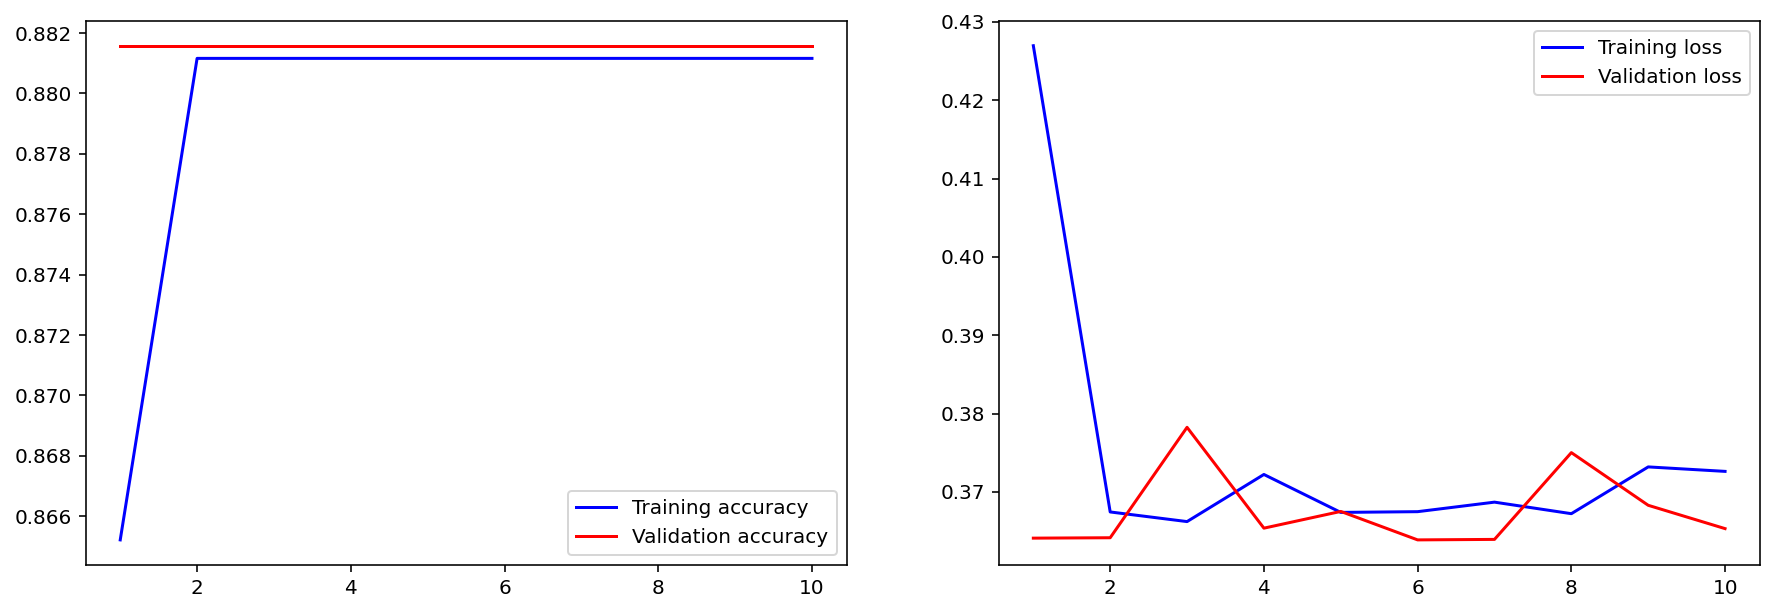

In [23]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']


epochs = range(1, len(acc)+1)
_,_ = plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
# Implement via CV


***

In [97]:
ht1 = features.dl_time_pivot(metadata, 765, max_time)
ht1

,time_bin,temp,temp_osc_time,mz_0_abund,mz_5_abund,mz_6_abund,mz_7_abund,mz_12_abund,mz_13_abund,mz_14_abund,...,mz_92_abund,mz_93_abund,mz_94_abund,mz_95_abund,mz_96_abund,mz_97_abund,mz_98_abund,mz_99_abund,sample_id,instrument_type
0,"[0.0, 10.0)",35.620765,0.198793,0.0,0.0,0.000002,0.000005,0.011006,0.000707,0.001775,...,0.000051,0.000046,0.000040,0.000034,0.000183,0.000149,0.000131,0.000029,S0765,sam_testbed
1,"[10.0, 20.0)",35.582467,0.259518,NaN,0.0,0.000000,0.000003,0.010468,0.000549,0.001709,...,0.000051,0.000034,0.000074,0.000046,0.000143,0.000137,0.000063,0.000017,S0765,sam_testbed
2,"[20.0, 30.0)",35.657034,0.191759,NaN,0.0,0.000000,0.000003,0.010033,0.000583,0.001732,...,0.000057,0.000046,0.000034,0.000017,0.000143,0.000109,0.000063,0.000000,S0765,sam_testbed
3,"[30.0, 40.0)",35.796819,0.232425,NaN,0.0,0.000007,0.000000,0.009330,0.000520,0.001761,...,0.000060,0.000060,0.000034,0.000043,0.000137,0.000214,0.000077,0.000011,S0765,sam_testbed
4,"[40.0, 50.0)",35.997046,0.266277,NaN,0.0,0.000006,0.000003,0.008610,0.000543,0.001847,...,0.000029,0.000057,0.000051,0.000091,0.000154,0.000149,0.000086,0.000017,S0765,sam_testbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,"[5200.0, 5210.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,sam_testbed
521,"[5210.0, 5220.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,sam_testbed
522,"[5220.0, 5230.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,sam_testbed
523,"[5230.0, 5240.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S0765,sam_testbed


In [83]:
ht1.time_bin.nunique()

525

In [93]:
ht = preprocess.get_sample(metadata, 765)
ht = preprocess.preprocess_samples(ht)

print(f'Rows: {ht.shape[0]}')
print(f'Ion rows: {ht.groupby("m/z")["m/z"].agg("count").unique()[0]}')

time_range = pd.interval_range(start=0.0, 
                               end=utils.roundup(max_time), 
                               freq=10, 
                               closed='left')
ht['time_bin'] = pd.cut(ht['time'], bins=time_range)
del ht['time']
#ht.sort_values(['m/z', 'time_bin'])

Rows: 116422
Ion rows: 1


In [96]:
ht_agg = ht.groupby(['m/z', 'time_bin']).agg('mean').reset_index()
print(ht_agg.shape)
ht_agg['temp_osc'] = ht_agg.groupby('time_bin')['temp'].transform('std')
ht_agg['temp'] = ht_agg.groupby('time_bin')['temp'].transform('mean')
ht_agg[ht_agg['time_bin'] == pd.Interval(0.0, 10.0, closed=('left'))].head(50)

(48300, 4)


,m/z,time_bin,temp,abun_minsub_scaled,temp_osc
0,0.0,"[0.0, 10.0)",35.620765,0.000000,0.198793
525,5.0,"[0.0, 10.0)",35.620765,0.000000,0.198793
1050,6.0,"[0.0, 10.0)",35.620765,0.000002,0.198793
1575,7.0,"[0.0, 10.0)",35.620765,0.000005,0.198793
2100,12.0,"[0.0, 10.0)",35.620765,0.011006,0.198793
2625,13.0,"[0.0, 10.0)",35.620765,0.000707,0.198793
3150,14.0,"[0.0, 10.0)",35.620765,0.001775,0.198793
3675,15.0,"[0.0, 10.0)",35.620765,0.009124,0.198793
4200,16.0,"[0.0, 10.0)",35.620765,0.055259,0.198793
4725,17.0,"[0.0, 10.0)",35.620765,0.271100,0.198793


In [55]:
ht = preprocess.get_sample(metadata, 765)
ht = preprocess.preprocess_samples(ht)

print(f'Rows: {ht.shape[0]}')
print(f'Ion rows: {ht.groupby("m/z")["m/z"].agg("count").unique()[0]}')

time_range = pd.interval_range(start=0.0, 
                               end=utils.roundup(max_time), 
                               freq=10, 
                               closed='left')
ht['time_bin'] = pd.cut(ht['time'], bins=time_range)
ht = ht[['time_bin', 'temp', 'm/z', 'abun_minsub_scaled']]


ht['temp'] = np.round(ht['temp'],0)
ht['temp_agg'] = ht.groupby(['time_bin', 'm/z'])['temp'].transform('mean')
del ht['temp']
ht.drop_duplicates(inplace=True)
ht['abun_agg'] = ht.groupby(['time_bin', 'temp_agg', 'm/z'])['abun_minsub_scaled']\
            .transform('mean')
del ht['abun_minsub_scaled']
ht.drop_duplicates(inplace=True)
    
ht.head()
#ht.head(25)
ht.sort_values(['time_bin', 'm/z'])

Rows: 116422
Ion rows: 1


,time_bin,m/z,temp_agg,abun_agg
0,"[0.0, 10.0)",0.0,36.000000,0.000000
1,"[0.0, 10.0)",5.0,35.142857,0.000000
2,"[0.0, 10.0)",6.0,35.285714,0.000009
3,"[0.0, 10.0)",7.0,35.142857,0.000009
4,"[0.0, 10.0)",12.0,35.500000,0.011006
...,...,...,...,...
141240,"[4200.0, 4210.0)",95.0,1048.000000,0.000017
141241,"[4200.0, 4210.0)",96.0,1046.000000,0.000017
141242,"[4200.0, 4210.0)",97.0,1048.000000,0.000069
141243,"[4200.0, 4210.0)",98.0,1048.000000,0.000034
